# The k-Armed Bandit Problem

A bandit is a slot machine with k arms, this is a simplified setting, one that does not involve learning to act in more than one situation (a.k.a. nonassociative setting.)

The actual reward from a bandit is stochastic, the algorithm learns a model of the Expected reward, and the actual reward is random with q∗(At) as mean (expectation) and variance 1.

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 10-armed bandits testbed (stationary distribution with state)

In [2]:
n = 50
k = 5
states = ['green', 'red', 'yellow']
models = {}
for s in states:
    models[s] = np.random.normal(0.0, 1.0, size=(n, k))

models['green'][0:1,:]

array([[ 0.19947898,  0.28274828, -0.59140333,  0.36054914,  0.03897608]])

In [3]:
# the bandit returns the actual reward from the true model
def bandit(s, iRow, a):
    r = models[s][iRow, a] + np.random.normal()
    return r

in a general reinforcement learning task there is more than one situation,
and the goal is to learn a policy: a mapping from situations to the actions that are
best in those situations.

### Action selection method: sample from a softmax (synthetic distribution based on preferences)
In this section we consider learning a numerical preference Ht(a) for each action a. The larger the preference, the more often that action is taken, but the preference has no interpretation in terms of reward. Only the relative preference of one action over another is important. 
The slot machine that changes the color of its display as it changes its action values. Now you can learn a policy associating each task, signaled by the color you see, with the best action to take when facing that
task—for instance, if red, select arm 1; if green, select arm 2.
This is an example of an associative search task, so called because it involves both trial-and-error learning in the form of search for the best actions and association of these actions with the situations in which they are best.

Full Reinforcemen Learning Process
1. read the curren state s
2. select the action-value that corresponds to s
3. select the best action according to one of the algorithms previously studied

In [4]:
# H : preference values for each action (logits)
# k : number of possible actions (number of arms in the bandit)
def soft_max_sampling(H, k):
    eH = np.exp(H)
    pi = eH/sum(eH)  # Boltzmann distribution (aka softmax)
    a = np.random.choice(range(k), p=pi)  # sample and action according to pi
    return a, pi

In [5]:
def update_rule(old_estimate, target, step_size):
    new_estimate = old_estimate + step_size * (target - old_estimate)
    return new_estimate

Initially all preferences are the same (e.g., H(a) = 0, ∀a) so that all actions have an equal probability of being selected.

In [12]:
alpha = 0.1 # learning rate / step-size
num_steps = 2000
state_time_series = np.random.choice(states, num_steps, p=[1/len(states) for _ in range(len(states))])
state_time_series[0:5]

array(['yellow', 'green', 'red', 'green', 'green'], 
      dtype='|S6')

In [13]:
# ratio for plotting performance
ratio_est_vs_opt = np.zeros(shape=(n, num_steps))
# accumulators for plotting performance
rewards_accum =   np.zeros(shape=(n, num_steps))
opt_rewards_accum =   np.zeros(shape=(n, num_steps)) + 1/10**6 # avoid division by zero at step zero
    
# for each model
for i in range(n):
    
    # action counters
    N = {}
    for s in states:
        N[s] = np.zeros(k) 
    
    # action preferences
    Hs = {}
    for s in states:
        #Hs[s] =  np.random.normal(1, 10**(-1), size=(k)) 
        Hs[s] =  np.zeros(k) 
    
    # average rewards up until time t
    mean_reward = {}
    for s in states:
        mean_reward[s] = 0.0
    
    # 1 run
    for t in range(num_steps): 
        
        # read the current state
        s = state_time_series[t]
        
        # select action, based on a learned soft-max distribution
        a, pi = soft_max_sampling(Hs[s], k)
        
        # act and collect the actual reward from the bandit
        reward = bandit(s, i, a)

        # update the average reward
        N[s][a] += 1
        mean_reward[s] = update_rule(mean_reward[s], reward, 1/N[s][a])
        
        # update the learned probabilities
        Hs[s][a] = Hs[s][a] + alpha * (reward - mean_reward[s]) * (1-pi[a])
        for j in range(k):
            if j != a:
                Hs[s][j] = Hs[s][j] - alpha * (reward - mean_reward[s]) * pi[j]
              
        # store the accumulators to calculate the ratio of epsilon-greedy vs optimal at each step for plotting
        if t > 0:
            rewards_accum[i, t] = rewards_accum[i, t-1] + reward
            opt_rewards_accum[i, t] = opt_rewards_accum[i, t-1] + bandit(s, i, np.argmax(models[s][i,:]))

# Compute ratio of cumulative rewards
# The stationary bandit test bed often contains commulative rewards that are close to zero
# I average over the 2000 models before computing the ratio

# mean along rows (avg of each step over all models)
avg_rewards_accum = np.mean(rewards_accum, 0)
avg_opt_rewards_accum = np.mean(opt_rewards_accum, 0)

#  average performance over all models
avg_ratio_est_vs_opt = avg_rewards_accum / avg_opt_rewards_accum

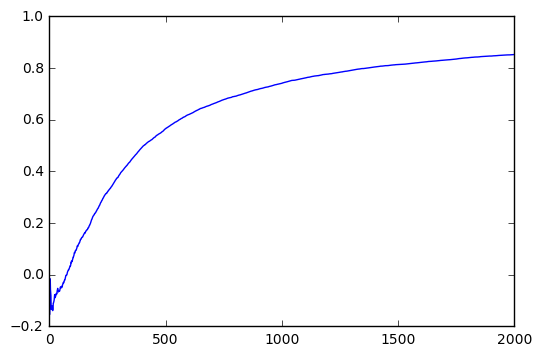

In [14]:
plt.plot(avg_ratio_est_vs_opt)  # try plotting 1 of each 100 point?